#### using YIN algorithm for melody extraction from monophonic audio. This was done in first few weeks while learning about melody extraction

In [1]:
!pip install llvmlite==0.31.0
import llvmlite
!pip install librosa

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

#### code for YIN algorithm

In [3]:
import scipy
from scipy.signal import fftconvolve
from os import sep
import time
from scipy.io.wavfile import read as wavread
import logging
from os import remove
import subprocess

def audio_read(audioFilePath, formatsox=False):
    logging.info('Reading of the audio file : ' + audioFilePath)
    if formatsox:
        tmpFile = "tmp.wav"
        logging.info('\t- Conversion en wav 16k with SOX.')
        cmd = "sox " + audioFilePath + " -c 1 -r 16k -b 16 -G " + tmpFile + " rate -m"
        subprocess.check_call(cmd)
        [sr, sig] = wavread(tmpFile)
        remove(tmpFile)
    else:
        [sr, sig] = wavread(audioFilePath)

    return sr, sig


def differenceFunction(x, N, tau_max):
    np.array(x, np.float64)
    w = x.size
    tau_max = min(tau_max, w)
    x_cumsum = np.concatenate((np.array([0.]), (x * x).cumsum()))
    size = w + tau_max
    p2 = (size // 32).bit_length()
    nice_numbers = (16, 18, 20, 24, 25, 27, 30, 32)
    size_pad = min(x * 2 ** p2 for x in nice_numbers if x * 2 ** p2 >= size)
    fc = np.fft.rfft(x, size_pad)
    conv = np.fft.irfft(fc * fc.conjugate())[:tau_max]
    return x_cumsum[w:w - tau_max:-1] + x_cumsum[w] - x_cumsum[:tau_max] - 2 * conv


def cumulativeMeanNormalizedDifferenceFunction(df, N):
    cmndf = df[1:] * range(1, N) / np.cumsum(df[1:]).astype(float) #scipy method
    return np.insert(cmndf, 0, 1)


def getPitch(cmdf, tau_min, tau_max, harmo_th=0.1):
    tau = tau_min
    while tau < tau_max:
        if cmdf[tau] < harmo_th:
            while tau + 1 < tau_max and cmdf[tau + 1] < cmdf[tau]:
                tau += 1
            return tau
        tau += 1

    return 0    # if unvoiced


def compute_yin(sig, sr, dataFileName=None, w_len=512, w_step=256, f0_min=100, f0_max=500, harmo_thresh=0.1):
    tau_min = int(sr / f0_max)
    tau_max = int(sr / f0_min)

    timeScale = range(0, len(sig) - w_len, w_step)  # time values for each analysis window
    times = [t/float(sr) for t in timeScale]
    frames = [sig[t:t + w_len] for t in timeScale]

    pitches = [0.0] * len(timeScale)
    harmonic_rates = [0.0] * len(timeScale)
    argmins = [0.0] * len(timeScale)

    for i, frame in enumerate(frames):
        #Compute YIN
        df = differenceFunction(frame, w_len, tau_max)
        cmdf = cumulativeMeanNormalizedDifferenceFunction(df, tau_max)
        p = getPitch(cmdf, tau_min, tau_max, harmo_thresh)

        #Get results
        if np.argmin(cmdf)>tau_min:
            argmins[i] = float(sr / np.argmin(cmdf))
        if p != 0: # A pitch was found
            pitches[i] = float(sr / p)
            harmonic_rates[i] = cmdf[p]
        else: # No pitch, but we compute a value of the harmonic rate
            harmonic_rates[i] = min(cmdf)

    if dataFileName is not None:
        np.savez(dataFileName, times=times, sr=sr, w_len=w_len, w_step=w_step, f0_min=f0_min, f0_max=f0_max, harmo_thresh=harmo_thresh, pitches=pitches, harmonic_rates=harmonic_rates, argmins=argmins)
        print('\t- Data file written in: ' + dataFileName)

    return pitches, harmonic_rates, argmins, times


def calculate(audioFileName, w_len=1875, w_step=331, f0_min=100, f0_max=500, harmo_thresh=0.01, audioDir="./", dataFileName=None, verbose=4):
    if audioDir is not None:
        audioFilePath = audioDir + sep + audioFileName
    else:
        audioFilePath = audioFileName
    
    x, sr = librosa.load(audioFileName)
    f,t,Z = scipy.signal.stft(x,sr,nperseg=4000)
    sr, sig = audio_read(audioFilePath, formatsox=False)
    duration = len(sig)/float(sr)
    
    pitches, harmonic_rates, argmins, times = compute_yin(sig, sr, dataFileName, w_len, w_step, f0_min, f0_max, harmo_thresh)

    for i in range(len(pitches)):
        if(pitches[i]>=f0_max and pitches[i]<=f0_max+5):
            pitches[i]=np.NaN
        if(pitches[i]==0):
            pitches[i]=np.NaN
            
    n = [float(x) * duration / len(pitches) for x in range(0, len(pitches))]
    plt.figure(figsize=(12,3))
    plt.ylim([0,1200])
    plt.title('stft + predicted melody')
    plt.plot(n,pitches,'r')
    plt.pcolormesh(t, f, np.abs(Z)**.6) ## if we use (np.abs(Z)**2) we will get spectrogram instead of STFT
    plt.show()
    
    plt.figure(figsize=(12,3))
    plt.ylim([0,1200])
    plt.title('stft only')
    plt.pcolormesh(t, f, np.abs(Z)**.6) ## if we use (np.abs(Z)**2) we will get spectrogram instead of STFT
    plt.show() 
    
    return pitches

In [4]:
!pip install mir_eval
import mir_eval

You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
wavfile = 'monophonic_data/train03.wav'
annotationfile = 'monophonic_data/train03.txt'

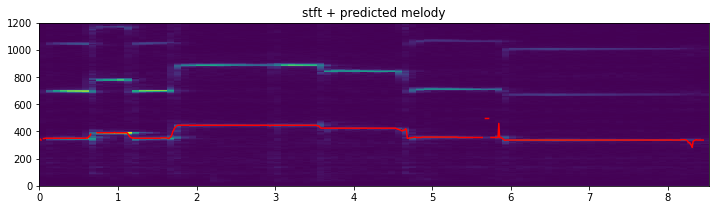

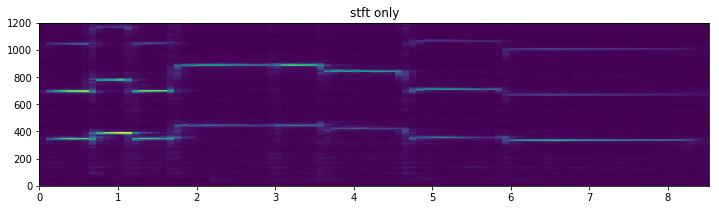

RPA = 92.65 percent


In [8]:
pitches = calculate(audioFileName=wavfile, w_len=1875, w_step=441, f0_min=100, f0_max=500)
### V.V.IMP : w_len, w_step, f0_min, f0_max needs to be tuned properly for every input audio file

import pandas
T = np.array(pandas.read_csv(annotationfile))
anno = np.empty(T.shape[0])
for i in range(len(anno)):
    if(T[i][0]=='--undefined--'):
        anno[i] = np.NaN
    else:
        anno[i] = T[i][0]

pitcharray = np.array(pitches)
## in calculate(), w_len and w_step should be chosen such as len(anno) and len(pitcharray) are close

### convert pitcharray and anno to cents
size = min(len(anno),len(pitcharray))
anno_cents = np.empty(size)
pitch_cents = np.empty(size)
for i in range(size):
    if(anno[i] == anno[i]):
        anno_cents[i] = (np.log(anno[i]/16.35)/np.log(2))*1200
    else:
        anno_cents[i] = 0 
    if(pitcharray[i] == pitcharray[i]):
        pitch_cents[i] = (np.log(pitcharray[i]/16.35)/np.log(2))*1200
    else:
        pitch_cents[i] = 0
        
voice = np.empty(size)
for i in range(size):
    voice[i] = True
        
rpa = mir_eval.melody.raw_pitch_accuracy(voice,anno_cents,voice,pitch_cents)
print('RPA = %.2f percent' %(rpa*100))

In [9]:
### above procedure is repeated for audio files in monophonc dataset to obtain RPA
### the average RPA will be around 67.02 % (if parameters are tuned properly for all audio files)